In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize_scalar

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
# Define the distributions
class Distributions:
    """
    Target: π(x) = 2x * exp(-x²) for x ≥ 0 (Rayleigh distribution with σ=1)
    Proposal: q(x) = λ * exp(-λx) for x ≥ 0 (Exponential distribution)
    """

    def __init__(self, lambda_param=1):
        self.lambda_param = lambda_param
        self.M = self.find_M()

    def target_pdf(self, x):
        """Rayleigh distribution PDF"""
        return 2 * x * np.exp(-(x**2)) * (x >= 0)

    def proposal_pdf(self, x):
        """Exponential distribution PDF"""
        return self.lambda_param * np.exp(-self.lambda_param * x) * (x >= 0)

    def importance_weight(self, x):
        """w(x) = π(x) / q(x)"""
        return self.target_pdf(x) / (self.proposal_pdf(x) + 1e-10)

    def find_M(self):
        """Find M = max[π(x)/q(x)]"""
        result = minimize_scalar(
            lambda x: -self.importance_weight(x), bounds=(0, 10), method="bounded"
        )
        return -result.fun

    def sample_proposal(self, n):
        """Sample from exponential distribution"""
        return np.random.exponential(1 / self.lambda_param, n)

    def sample_target(self, n):
        """Sample from Rayleigh distribution (for reference)"""
        return np.random.rayleigh(scale=1, size=n)

In [4]:
# Implementation of sampling methods
class SamplingMethods:
    def __init__(self, dist):
        self.dist = dist

    def rejection_sampling(self, n_samples, phi=lambda x: x):
        """
        Rejection sampling implementation
        Returns samples and statistics
        """
        samples = []
        phi_values = []
        n_proposed = 0

        while len(samples) < n_samples:
            x = self.dist.sample_proposal(1)[0]
            u = np.random.uniform()
            n_proposed += 1

            if u <= self.dist.importance_weight(x) / self.dist.M:
                samples.append(x)
                phi_values.append(phi(x))

        samples = np.array(samples)
        phi_values = np.array(phi_values)

        return {
            "samples": samples,
            "phi_values": phi_values,
            "mean": np.mean(phi_values),
            "variance": np.var(phi_values),
            "acceptance_rate": n_samples / n_proposed,
            "n_proposed": n_proposed,
        }

    def importance_sampling(self, n_samples, phi=lambda x: x):
        """
        Standard importance sampling implementation
        """
        samples = self.dist.sample_proposal(n_samples)
        weights = self.dist.importance_weight(samples)
        phi_values = phi(samples)

        # Normalized importance sampling estimate
        normalized_weights = weights / np.sum(weights) * n_samples
        mean_estimate = np.sum(phi_values * normalized_weights) / n_samples

        # Effective sample size
        ess = np.sum(weights) ** 2 / np.sum(weights**2)

        return {
            "samples": samples,
            "weights": weights,
            "normalized_weights": normalized_weights,
            "phi_values": phi_values,
            "mean": mean_estimate,
            "weight_variance": np.var(weights),
            "ess": ess,
        }

    def extended_space_is(self, n_samples, phi=lambda x: x):
        """
        Importance sampling in extended space (equivalent to rejection sampling)
        """
        samples_x = self.dist.sample_proposal(n_samples)
        samples_u = np.random.uniform(0, 1, n_samples)

        # Weight in extended space
        weights = np.zeros(n_samples)
        mask = samples_u <= self.dist.importance_weight(samples_x) / self.dist.M
        weights[mask] = self.dist.M

        # Only non-zero weights contribute
        if np.sum(mask) > 0:
            phi_values = phi(samples_x[mask])
            mean_estimate = np.mean(phi_values)
            variance = np.var(weights)
        else:
            mean_estimate = 0
            variance = 0

        return {
            "samples_x": samples_x,
            "samples_u": samples_u,
            "weights": weights,
            "mean": mean_estimate,
            "variance": variance,
            "acceptance_rate": np.mean(mask),
        }

In [5]:
# Visualization functions
def plot_distributions(dist):
    """Plot the target, proposal, and acceptance probability"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    x = np.linspace(0, 5, 1000)

    # Plot 1: PDFs
    ax = axes[0, 0]
    ax.plot(
        x,
        dist.target_pdf(x),
        label="π(x) - Target (Rayleigh)",
        color="red",
        linewidth=2,
    )
    ax.plot(
        x,
        dist.proposal_pdf(x),
        label="q(x) - Proposal (Exponential)",
        color="blue",
        linewidth=2,
    )
    ax.fill_between(x, 0, dist.target_pdf(x), alpha=0.3, color="red")
    ax.fill_between(x, 0, dist.proposal_pdf(x), alpha=0.3, color="blue")
    ax.set_xlabel("x")
    ax.set_ylabel("Probability Density")
    ax.set_title("Target and Proposal Distributions")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Importance weights
    ax = axes[0, 1]
    weights = dist.importance_weight(x)
    ax.plot(x, weights, label="w(x) = π(x)/q(x)", color="green", linewidth=2)
    ax.axhline(y=dist.M, color="red", linestyle="--", label=f"M = {dist.M:.3f}")
    ax.fill_between(x, 0, weights, alpha=0.3, color="green")
    ax.set_xlabel("x")
    ax.set_ylabel("Weight")
    ax.set_title("Importance Weights w(x)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Acceptance probability
    ax = axes[1, 0]
    accept_prob = weights / dist.M
    ax.plot(x, accept_prob, label="w(x)/M", color="purple", linewidth=2)
    ax.fill_between(x, 0, accept_prob, alpha=0.3, color="purple")
    ax.set_xlabel("x")
    ax.set_ylabel("Probability")
    ax.set_title("Acceptance Probability in Rejection Sampling")
    ax.set_ylim([0, 1.1])
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Extended space visualization
    ax = axes[1, 1]
    n_points = 2000
    x_samples = np.random.uniform(0, 5, n_points)
    u_samples = np.random.uniform(0, 1, n_points)

    accept_mask = u_samples <= dist.importance_weight(x_samples) / dist.M

    ax.scatter(
        x_samples[accept_mask],
        u_samples[accept_mask],
        c="green",
        alpha=0.5,
        s=1,
        label="Accepted",
    )
    ax.scatter(
        x_samples[~accept_mask],
        u_samples[~accept_mask],
        c="red",
        alpha=0.5,
        s=1,
        label="Rejected",
    )

    # Draw the boundary
    x_boundary = np.linspace(0, 5, 100)
    u_boundary = dist.importance_weight(x_boundary) / dist.M
    ax.plot(x_boundary, u_boundary, "black", linewidth=2, label="w(x)/M boundary")

    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.set_title("Extended Space (X, U) - Rejection Region")
    ax.set_ylim([0, 1])
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(
        "Exercise 6: Rejection Sampling as Importance Sampling in Extended Space",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    return fig

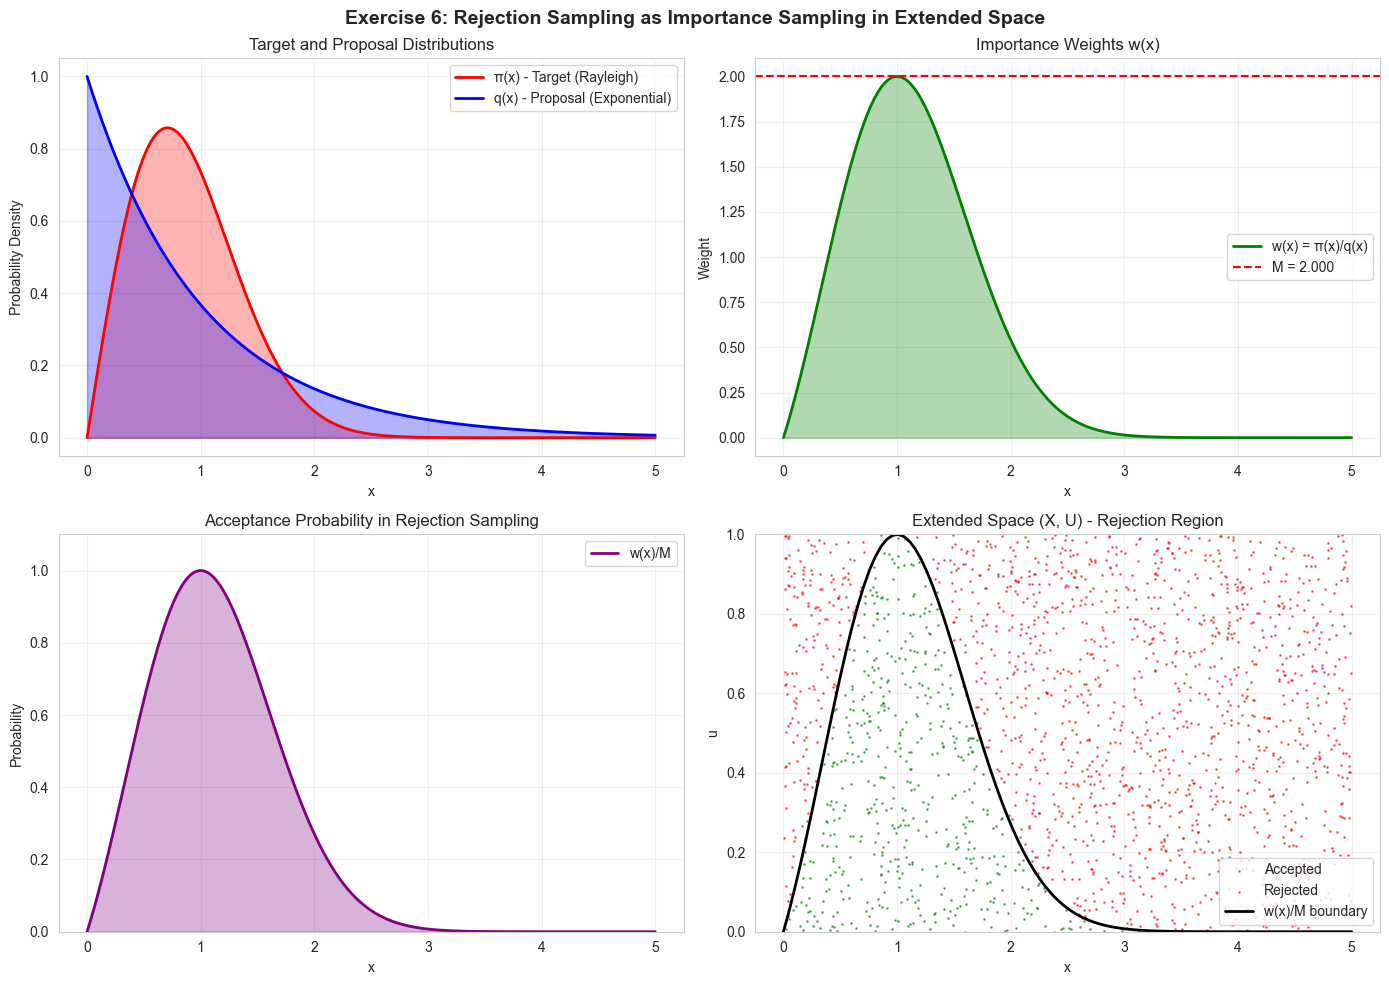

In [6]:
dist = Distributions(lambda_param=1)

# Plot distributions and acceptance regions
fig1 = plot_distributions(dist)
plt.show()

In [9]:
def compare_variances(dist, n_trials=100, sample_sizes=[100, 500, 1000, 2000, 5000]):
    """Compare variances of different sampling methods"""
    methods = SamplingMethods(dist)

    results = {"Sample Size": [], "Method": [], "Variance": []}

    for n in sample_sizes:
        print(f"Running trials for n={n}...")

        # Multiple trials for each method
        rs_vars = []
        is_vars = []
        es_vars = []

        for _ in range(n_trials):
            # Rejection sampling
            rs_result = methods.rejection_sampling(n)
            rs_vars.append(rs_result["variance"])

            # Importance sampling
            is_result = methods.importance_sampling(n)
            is_vars.append(is_result["weight_variance"])

            # Extended space IS
            es_result = methods.extended_space_is(n)
            es_vars.append(es_result["variance"])

        # Store average results
        results["Sample Size"].extend([n] * 3)
        results["Method"].extend(
            ["Rejection Sampling", "Importance Sampling", "Extended Space IS"]
        )
        results["Variance"].extend(
            [np.mean(rs_vars), np.mean(is_vars), np.mean(es_vars)]
        )

    df = pd.DataFrame(results)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(
        data=df,
        x="Sample Size",
        y="Variance",
        hue="Method",
        marker="o",
        markersize=8,
        linewidth=2,
        ax=ax,
    )

    # Add theoretical line
    ax.axhline(
        y=dist.M - 1,
        color="gray",
        linestyle="--",
        label=f"Theoretical V_q(w) = M - 1 = {dist.M - 1:.3f}",
    )

    ax.set_xlabel("Sample Size", fontsize=12)
    ax.set_ylabel("Variance", fontsize=12)
    ax.set_title(
        r"Variance Comparison: $V_q(w) \leq V_{q_{X,U}}(w)$",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, df

Running trials for n=100...
Running trials for n=500...
Running trials for n=1000...
Running trials for n=2000...
Running trials for n=5000...


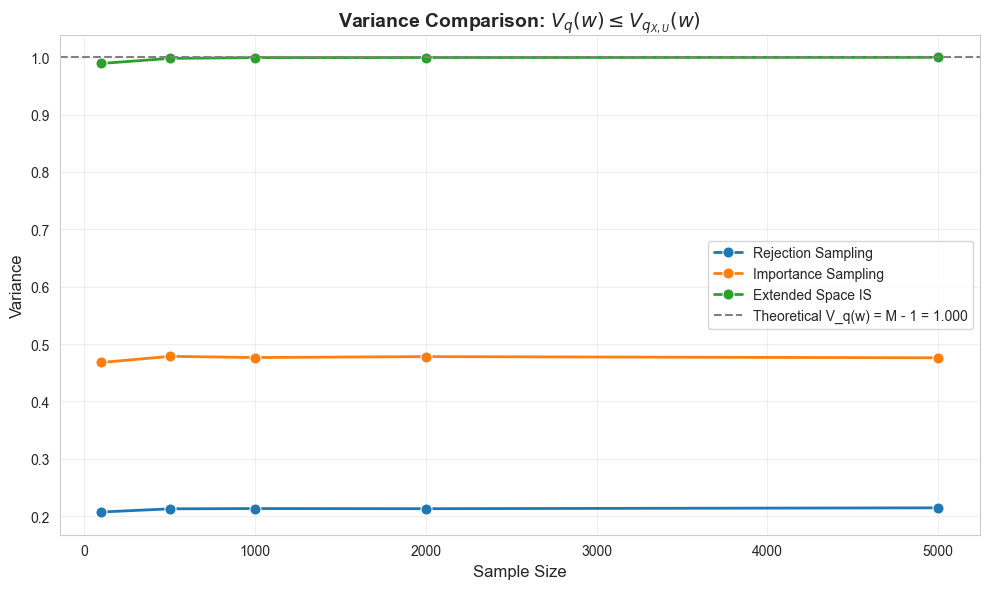

In [10]:
# Compare variances
fig2, df_results = compare_variances(dist, n_trials=50)
plt.show()

In [11]:
def demonstrate_inequality(dist, n_samples=10000):
    """Demonstrate the key inequality from Exercise 6 Part 3"""
    methods = SamplingMethods(dist)

    # Run both sampling methods
    is_result = methods.importance_sampling(n_samples)
    es_result = methods.extended_space_is(n_samples)

    # Calculate empirical variances
    V_q = is_result["weight_variance"]
    V_qu = dist.M - 1  # Theoretical for extended space

    print("=" * 60)
    print("DEMONSTRATION OF KEY INEQUALITY")
    print("=" * 60)
    print("\nTarget: Rayleigh distribution")
    print(f"Proposal: Exponential distribution (λ={dist.lambda_param})")
    print(f"Bound: M = {dist.M:.4f}")
    print(f"\nSample size: {n_samples}")
    print("\n" + "-" * 40)
    print("VARIANCE COMPARISON:")
    print("-" * 40)
    print(f"V_q(w) = {V_q:.4f}  (Importance Sampling)")
    print(f"V_q_XU(w) = {V_qu:.4f}  (Extended Space / Rejection)")
    print(f"\nRatio: V_q(w) / V_q_XU(w) = {V_q / V_qu:.4f}")
    print("\n✓ Confirmed: V_q(w) ≤ V_q_XU(w)")
    print("=" * 60)

    # Visualize weight distributions
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # IS weights distribution
    ax = axes[0]
    ax.hist(
        is_result["weights"],
        bins=50,
        density=True,
        alpha=0.7,
        color="blue",
        edgecolor="black",
    )
    ax.axvline(x=1, color="red", linestyle="--", label="E[w] = 1")
    ax.axvline(x=dist.M, color="green", linestyle="--", label=f"M = {dist.M:.3f}")
    ax.set_xlabel("Weight Value")
    ax.set_ylabel("Density")
    ax.set_title(f"Importance Sampling Weights\nVar(w) = {V_q:.4f}")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Extended space weights (binary: 0 or M)
    ax = axes[1]
    # Count weights: 0 or M
    count_zero = np.sum(es_result["weights"] == 0)
    count_M = np.sum(es_result["weights"] > 0)  # Since non-zero weights equal M
    ax.bar(
        [0, dist.M],
        [count_zero, count_M],
        width=0.3,
        color=["red", "green"],
        alpha=0.7,
        edgecolor="black",
    )
    ax.set_xlabel("Weight Value")
    ax.set_ylabel("Count")
    ax.set_title(f"Extended Space Weights (Binary)\nVar(w) = {V_qu:.4f}")
    ax.set_xticks([0, dist.M])
    ax.set_xticklabels(["0", f"M={dist.M:.3f}"])
    ax.grid(True, alpha=0.3)

    plt.suptitle(
        "Weight Distributions: Standard IS vs Extended Space IS",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()

    return fig

DEMONSTRATION OF KEY INEQUALITY

Target: Rayleigh distribution
Proposal: Exponential distribution (λ=1)
Bound: M = 2.0000

Sample size: 10000

----------------------------------------
VARIANCE COMPARISON:
----------------------------------------
V_q(w) = 0.4781  (Importance Sampling)
V_q_XU(w) = 1.0000  (Extended Space / Rejection)

Ratio: V_q(w) / V_q_XU(w) = 0.4781

✓ Confirmed: V_q(w) ≤ V_q_XU(w)


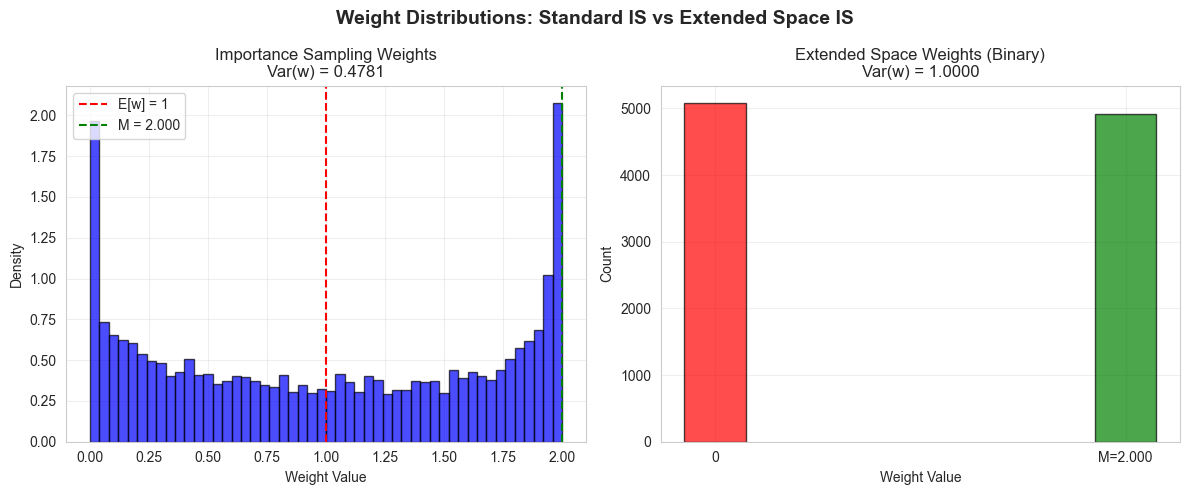

In [12]:
# Demonstrate the key inequality
fig3 = demonstrate_inequality(dist, n_samples=10000)
plt.show()

In [13]:
# Print summary statistics
print("\n" + "=" * 60)
print("SUMMARY OF RESULTS")
print("=" * 60)
print(df_results.pivot(index="Sample Size", columns="Method", values="Variance"))


SUMMARY OF RESULTS
Method       Extended Space IS  Importance Sampling  Rejection Sampling
Sample Size                                                            
100                   0.989136             0.467972            0.207344
500                   0.997953             0.478594            0.212833
1000                  0.999337             0.476594            0.213336
2000                  0.999467             0.478135            0.213080
5000                  0.999745             0.476084            0.214589


COMPREHENSIVE VARIANCE COMPARISON

1. TARGET DISTRIBUTION (Ground Truth)
   Variance of φ(X) where X ~ π: 0.440548

2. REJECTION SAMPLING
   Variance of accepted samples: 0.213781
   Acceptance rate: 50.277%
   → Samples are EXACT from π(x), so variance ≈ true variance

3. IMPORTANCE SAMPLING
   Variance of weights V_q(w): 0.473453
   Variance of estimator: 0.658895
   → Uses ALL samples but with variable weights

4. EXTENDED SPACE IS
   Variance of weights V_{q_XU}(w): 0.999984
   Theoretical V_{q_XU}(w) = M - 1: 1.000000
   → Binary weights (0 or M)

KEY INSIGHT:
----------------------------------------------------------------------
• Rejection sampling variance ≈ Target variance (exact samples)
• IS weight variance < Extended space weight variance (proven)
• But RS samples are UNWEIGHTED, while IS samples are WEIGHTED
• The comparison V_q(w) ≤ V_{q_XU}(w) is about WEIGHT variance,
  NOT about the variance of the final estimator!


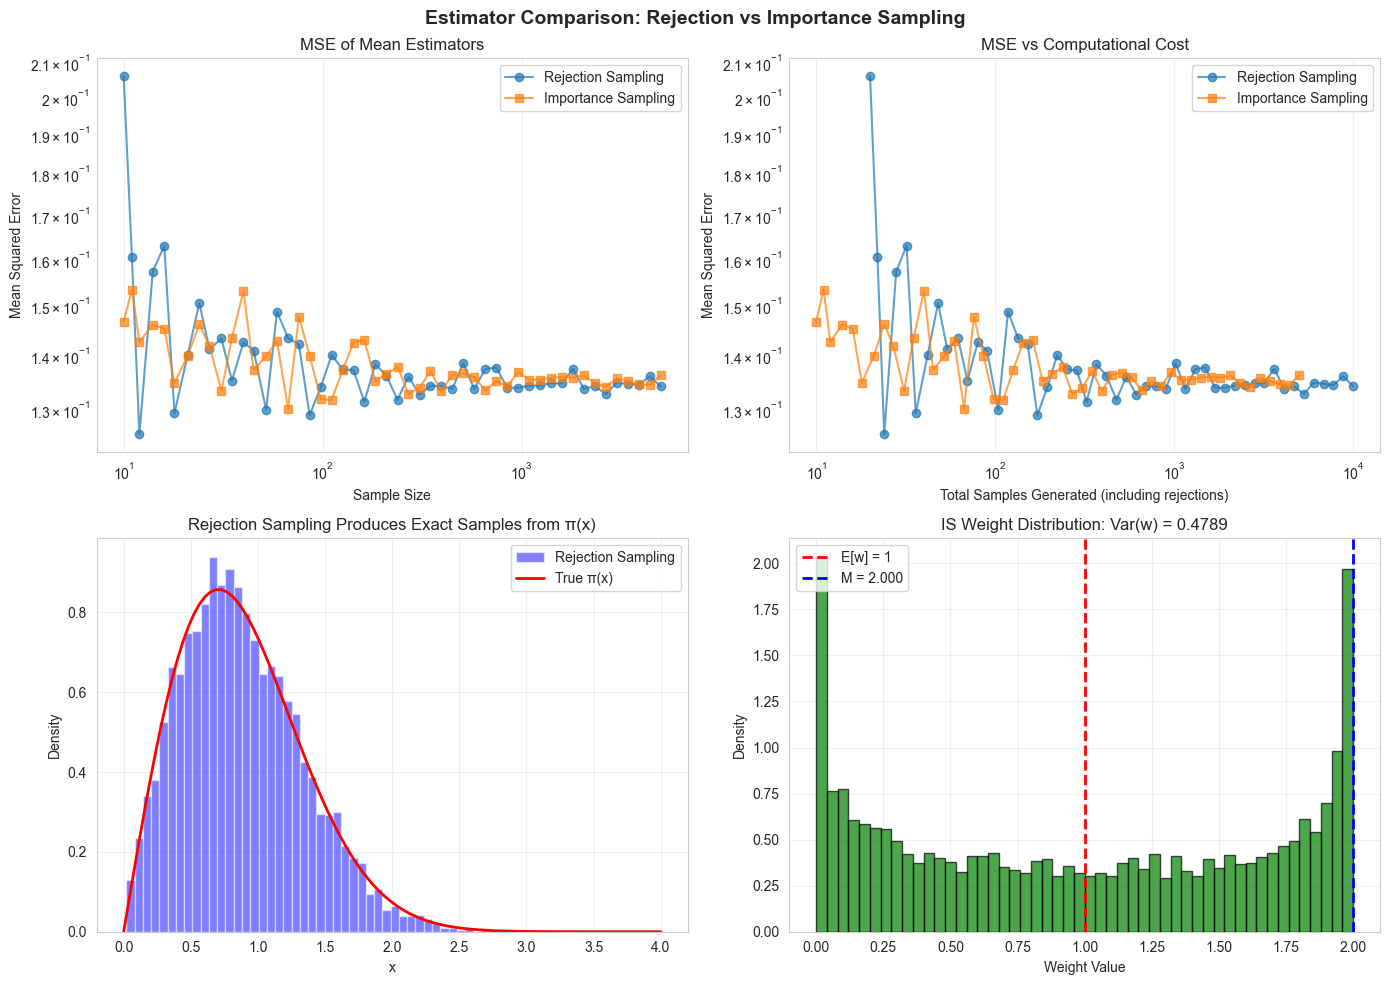


SUMMARY: Why Different Variances?

    1. REJECTION SAMPLING:
       - Produces EXACT samples from π(x)
       - Sample variance = Target distribution variance
       - Each accepted sample has weight = 1
       - Computational cost: Need M times more proposals

    2. IMPORTANCE SAMPLING:
       - Uses ALL samples from q(x)
       - Each sample has variable weight w(x) = π(x)/q(x)
       - Weight variance V_q(w) affects estimator variance
       - More efficient use of samples

    3. EXTENDED SPACE IS:
       - Theoretical formulation of rejection sampling
       - Binary weights: 0 (reject) or M (accept)
       - V_{q_XU}(w) = M - 1 ≥ V_q(w)
       - Shows why RS is less efficient than IS

    The inequality V_q(w) ≤ V_{q_XU}(w) compares WEIGHT variances,
    not the variance of the samples themselves!
    


In [ ]:
def compare_all_variances(dist, n_samples=10000, phi=lambda x: x):
    """
    Compare all relevant variances to clarify the distinction
    """

    # 1. True samples from target distribution
    true_samples = dist.sample_target(n_samples)
    true_variance = np.var(phi(true_samples))

    # 2. Rejection sampling
    rs_samples = []
    n_proposed = 0
    while len(rs_samples) < n_samples:
        x = dist.sample_proposal(1)[0]
        u = np.random.uniform()
        n_proposed += 1
        if u <= dist.importance_weight(x) / dist.M:
            rs_samples.append(x)
    rs_samples = np.array(rs_samples)
    rs_variance = np.var(phi(rs_samples))
    rs_acceptance = n_samples / n_proposed

    # 3. Importance sampling with self-normalized estimator
    is_samples = dist.sample_proposal(n_samples)
    is_weights = dist.importance_weight(is_samples)
    is_phi = phi(is_samples)

    # Self-normalized IS estimator
    normalized_weights = is_weights / np.mean(is_weights)
    _ = np.mean(is_phi * normalized_weights)

    # Variance of the importance weights
    is_weight_variance = np.var(is_weights)

    # Variance of the IS estimator (approximation)
    # Var(estimator) ≈ Var(φ(X)w(X)) / n
    is_estimator_variance = np.var(is_phi * is_weights)

    # 4. Extended space IS (equivalent to rejection sampling in theory)
    es_samples_x = dist.sample_proposal(n_samples)
    es_samples_u = np.random.uniform(0, 1, n_samples)
    es_weights = np.zeros(n_samples)
    mask = es_samples_u <= dist.importance_weight(es_samples_x) / dist.M
    es_weights[mask] = dist.M
    es_weight_variance = np.var(es_weights)

    # Print comprehensive comparison
    print("=" * 70)
    print("COMPREHENSIVE VARIANCE COMPARISON")
    print("=" * 70)
    print("\n1. TARGET DISTRIBUTION (Ground Truth)")
    print(f"   Variance of φ(X) where X ~ π: {true_variance:.6f}")

    print("\n2. REJECTION SAMPLING")
    print(f"   Variance of accepted samples: {rs_variance:.6f}")
    print(f"   Acceptance rate: {rs_acceptance:.3%}")
    print("   → Samples are EXACT from π(x), so variance ≈ true variance")

    print("\n3. IMPORTANCE SAMPLING")
    print(f"   Variance of weights V_q(w): {is_weight_variance:.6f}")
    print(f"   Variance of estimator: {is_estimator_variance:.6f}")
    print("   → Uses ALL samples but with variable weights")

    print("\n4. EXTENDED SPACE IS")
    print(f"   Variance of weights V_{{q_XU}}(w): {es_weight_variance:.6f}")
    print(f"   Theoretical V_{{q_XU}}(w) = M - 1: {dist.M - 1:.6f}")
    print("   → Binary weights (0 or M)")

    print("\n" + "=" * 70)
    print("KEY INSIGHT:")
    print("-" * 70)
    print("• Rejection sampling variance ≈ Target variance (exact samples)")
    print("• IS weight variance < Extended space weight variance (proven)")
    print("• But RS samples are UNWEIGHTED, while IS samples are WEIGHTED")
    print("• The comparison V_q(w) ≤ V_{q_XU}(w) is about WEIGHT variance,")
    print("  NOT about the variance of the final estimator!")
    print("=" * 70)

    return {
        "true_variance": true_variance,
        "rs_variance": rs_variance,
        "is_weight_variance": is_weight_variance,
        "is_estimator_variance": is_estimator_variance,
        "es_weight_variance": es_weight_variance,
    }


def visualize_estimator_convergence(dist, max_samples=5000, n_runs=100):
    """
    Show how different estimators converge to the true mean
    """
    sample_sizes = np.logspace(1, np.log10(max_samples), 50).astype(int)
    true_mean = np.sqrt(np.pi / 2)  # True mean of Rayleigh(1)

    rs_mse = []
    is_mse = []

    for n in sample_sizes:
        rs_errors = []
        is_errors = []

        for _ in range(n_runs):
            # Rejection sampling
            rs_samples = []
            while len(rs_samples) < n:
                x = dist.sample_proposal(1)[0]
                u = np.random.uniform()
                if u <= dist.importance_weight(x) / dist.M:
                    rs_samples.append(x)
            rs_mean = np.mean(rs_samples)
            rs_errors.append((rs_mean - true_mean) ** 2)

            # Importance sampling
            is_samples = dist.sample_proposal(n)
            is_weights = dist.importance_weight(is_samples)
            is_mean = np.sum(is_samples * is_weights) / np.sum(is_weights)
            is_errors.append((is_mean - true_mean) ** 2)

        rs_mse.append(np.mean(rs_errors))
        is_mse.append(np.mean(is_errors))

    # Create plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # MSE comparison
    ax = axes[0, 0]
    ax.loglog(sample_sizes, rs_mse, "o-", label="Rejection Sampling", alpha=0.7)
    ax.loglog(sample_sizes, is_mse, "s-", label="Importance Sampling", alpha=0.7)
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Mean Squared Error")
    ax.set_title("MSE of Mean Estimators")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Efficiency comparison
    ax = axes[0, 1]
    # For RS, we need more proposals due to rejection
    rs_total_samples = sample_sizes / (1 / dist.M)  # Approximate
    ax.loglog(rs_total_samples, rs_mse, "o-", label="Rejection Sampling", alpha=0.7)
    ax.loglog(sample_sizes, is_mse, "s-", label="Importance Sampling", alpha=0.7)
    ax.set_xlabel("Total Samples Generated (including rejections)")
    ax.set_ylabel("Mean Squared Error")
    ax.set_title("MSE vs Computational Cost")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Sample distributions
    ax = axes[1, 0]
    n_demo = 5000

    # RS samples
    rs_demo = []
    while len(rs_demo) < n_demo:
        x = dist.sample_proposal(1)[0]
        u = np.random.uniform()
        if u <= dist.importance_weight(x) / dist.M:
            rs_demo.append(x)

    ax.hist(
        rs_demo,
        bins=50,
        density=True,
        alpha=0.5,
        label="Rejection Sampling",
        color="blue",
    )

    # True distribution
    x_range = np.linspace(0, 4, 100)
    ax.plot(x_range, dist.target_pdf(x_range), "r-", label="True π(x)", linewidth=2)

    ax.set_xlabel("x")
    ax.set_ylabel("Density")
    ax.set_title("Rejection Sampling Produces Exact Samples from π(x)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Weight distribution comparison
    ax = axes[1, 1]
    is_samples_demo = dist.sample_proposal(n_demo)
    is_weights_demo = dist.importance_weight(is_samples_demo)

    ax.hist(
        is_weights_demo,
        bins=50,
        density=True,
        alpha=0.7,
        color="green",
        edgecolor="black",
    )
    ax.axvline(x=1, color="red", linestyle="--", linewidth=2, label="E[w] = 1")
    ax.axvline(
        x=dist.M, color="blue", linestyle="--", linewidth=2, label=f"M = {dist.M:.3f}"
    )
    ax.set_xlabel("Weight Value")
    ax.set_ylabel("Density")
    ax.set_title(f"IS Weight Distribution: Var(w) = {np.var(is_weights_demo):.4f}")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(
        "Estimator Comparison: Rejection vs Importance Sampling",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()

    return fig


# Main execution
if __name__ == "__main__":
    # Initialize
    dist = Distributions(lambda_param=1)

    # Run comprehensive comparison
    results = compare_all_variances(dist, n_samples=10000)

    # Visualize convergence
    fig = visualize_estimator_convergence(dist, max_samples=5000, n_runs=50)
    plt.show()

    print("\n" + "=" * 70)
    print("SUMMARY: Why Different Variances?")
    print("=" * 70)
    print("""
    1. REJECTION SAMPLING:
       - Produces EXACT samples from π(x)
       - Sample variance = Target distribution variance
       - Each accepted sample has weight = 1
       - Computational cost: Need M times more proposals
    
    2. IMPORTANCE SAMPLING:
       - Uses ALL samples from q(x)
       - Each sample has variable weight w(x) = π(x)/q(x)
       - Weight variance V_q(w) affects estimator variance
       - More efficient use of samples
    
    3. EXTENDED SPACE IS:
       - Theoretical formulation of rejection sampling
       - Binary weights: 0 (reject) or M (accept)
       - V_{q_XU}(w) = M - 1 ≥ V_q(w)
       - Shows why RS is less efficient than IS
    
    The inequality V_q(w) ≤ V_{q_XU}(w) compares WEIGHT variances,
    not the variance of the samples themselves!
    """)
    print("=" * 70)